# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using Plots
using StatsBase

include("../../lib.jl")

ENV["LINES"]=30;

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278
┌ Info: Precompiling MLJ [add582a8-e3ab-11e8-2d5e-e98b27df1bc7]
└ @ Base loading.jl:1278
[ Info: Model metadata loaded from registry. 
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


# Datasets

In [2]:
data = CSV.read("./data.csv")

,Mean of the integrated profile,Standard deviation of the integrated profile
,Float64,Float64
1,140.562,55.6838
2,102.508,58.8824
3,103.016,39.3416
4,136.75,57.1784
5,88.7266,40.6722
6,93.5703,46.6981
7,119.484,48.7651
8,130.383,39.8441
9,107.25,52.6271


In [3]:
describe(data)

,variable,mean,min,median,max
,Symbol,Float64,Real,Float64,Real
1,Mean of the integrated profile,111.08,5.8125,115.078,192.617
2,Standard deviation of the integrated profile,46.5495,24.772,46.9475,98.7789
3,Excess kurtosis of the integrated profile,0.477857,-1.87601,0.22324,8.06952
4,Skewness of the integrated profile,1.77028,-1.79189,0.19871,68.1016
5,Mean of the DM-SNR curve,12.6144,0.213211,2.80184,223.392
6,Standard deviation of the DM-SNR curve,26.3265,7.37043,18.4613,110.642
7,Excess kurtosis of the DM-SNR curve,8.30356,-3.13927,8.43351,34.5398
8,Skewness of the DM-SNR curve,104.858,-1.97698,83.0646,1191.0
9,target_class,0.0915745,0,0.0,1


Look at class labels to see if dataset is imbalanced

In [4]:
label_counts = countmap(data[:target_class])

Dict{Int64,Int64} with 2 entries:
  0 => 16259
  1 => 1639

In [5]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

2-element Array{Float64,1}:
 0.908425522404738
 0.09157447759526204

Get data ready for training

In [6]:
coerce!(data, :target_class=>OrderedFactor)
schema(data)

┌───────────────────────────────────────────────┬────────────────────────────────┬──────────────────┐
│ _.names                                       │ _.types                        │ _.scitypes       │
├───────────────────────────────────────────────┼────────────────────────────────┼──────────────────┤
│  Mean of the integrated profile               │ Float64                        │ Continuous       │
│  Standard deviation of the integrated profile │ Float64                        │ Continuous       │
│  Excess kurtosis of the integrated profile    │ Float64                        │ Continuous       │
│  Skewness of the integrated profile           │ Float64                        │ Continuous       │
│  Mean of the DM-SNR curve                     │ Float64                        │ Continuous       │
│  Standard deviation of the DM-SNR curve       │ Float64                        │ Continuous       │
│  Excess kurtosis of the DM-SNR curve          │ Float64                        │

In [7]:
y, X = unpack(data, ==(:target_class), colname->true)

(CategoricalValue{Int64,UInt32}[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 17898×8 DataFrame. Omitted printing of 7 columns
│ Row   │  Mean of the integrated profile │
│       │ Float64                         │
├───────┼─────────────────────────────────┤
│ 1     │ 140.562                         │
│ 2     │ 102.508                         │
│ 3     │ 103.016                         │
│ 4     │ 136.75                          │
│ 5     │ 88.7266                         │
│ 6     │ 93.5703                         │
│ 7     │ 119.484                         │
│ 8     │ 130.383                         │
│ 9     │ 107.25                          │
│ 10    │ 107.258                         │
⋮
│ 17888 │ 121.375                         │
│ 17889 │ 98.7266                         │
│ 17890 │ 126.625                         │
│ 17891 │ 143.672                         │
│ 17892 │ 118.484                         │
│ 17893 │ 96.0                            │
│ 17894 │ 136.43 

Partition train and test data accoring to class labels

In [8]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=145) # gives 70:30 split

([126, 4772, 16468, 10267, 7540, 15204, 761, 13099, 974, 15987  …  5779, 10399, 14158, 437, 14699, 14844, 16953, 10720, 2135, 12596], [13316, 11354, 9889, 12477, 4399, 9104, 17818, 13281, 722, 5074  …  13425, 15293, 7136, 1508, 15041, 10370, 2519, 1372, 9098, 17193])

In [9]:
train_counts = countmap(data[train,:target_class])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

2-element Array{Float64,1}:
 0.9090909090909091
 0.09090909090909091

In [10]:
test_counts = countmap(data[test,:target_class])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

2-element Array{Float64,1}:
 0.9068727882287204
 0.09312721177127957

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [11]:
models(matching(X,y))

43-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [12]:
@load SVMClassifier

┌ Info: Precompiling MLJScikitLearnInterface [5ae90465-5518-4432-b9d2-8a1def2f0cab]
└ @ Base loading.jl:1278


SVMClassifier(
    C = 1.0,
    kernel = "rbf",
    degree = 3,
    gamma = "auto",
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 200,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @358

### Support Vector Machines
* This should be done in such a way that you can swap out kernel functions. I'd like to see at least two.

In [13]:
svm_model = SVMClassifier(kernel="linear")
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @523.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:01:45


┌───────────┬───────────────┬──────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                               │
├───────────┼───────────────┼──────────────────────────────────────────┤
│ accuracy  │ 0.979         │ [0.982, 0.985, 0.978, 0.98, 0.973, 0.98] │
└───────────┴───────────────┴──────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [14]:
svm_model = SVMClassifier(kernel="sigmoid")
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @300.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:03


┌───────────┬───────────────┬───────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                │
├───────────┼───────────────┼───────────────────────────────────────────┤
│ accuracy  │ 0.908         │ [0.904, 0.896, 0.917, 0.916, 0.906, 0.91] │
└───────────┴───────────────┴───────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [15]:
svm_model = SVMClassifier(kernel="rbf")
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @010.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:01:59


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.911         │ [0.907, 0.908, 0.922, 0.908, 0.906, 0.913] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


Poly Degree 2 took a long wall clock time

In [16]:
# svm_model = SVMClassifier(kernel="poly", degree=2)
# svm_mach = machine(svm_model, X, y)
# fit!(svm_mach, rows=train, verbosity=2)
# svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
#                         verbosity=1)

##### With Standardization

In [17]:
standardizer = Standardizer()
stand = machine(standardizer, X[train,:])
fit!(stand)
X_stand = MLJ.transform(stand, X);

┌ Info: Training Machine{Standardizer} @760.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


In [18]:
svm_model = SVMClassifier(kernel="linear")
svm_mach = machine(svm_model, X_stand, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @957.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:01


┌───────────┬───────────────┬──────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                               │
├───────────┼───────────────┼──────────────────────────────────────────┤
│ accuracy  │ 0.979         │ [0.977, 0.98, 0.98, 0.982, 0.977, 0.981] │
└───────────┴───────────────┴──────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [19]:
svm_model = SVMClassifier(kernel="sigmoid")
svm_mach = machine(svm_model, X_stand, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @913.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:09


┌───────────┬───────────────┬───────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                │
├───────────┼───────────────┼───────────────────────────────────────────┤
│ accuracy  │ 0.872         │ [0.872, 0.872, 0.87, 0.866, 0.877, 0.876] │
└───────────┴───────────────┴───────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [20]:
svm_model = SVMClassifier(kernel="rbf")
svm_mach = machine(svm_model, X_stand, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @496.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:02


┌───────────┬───────────────┬───────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                │
├───────────┼───────────────┼───────────────────────────────────────────┤
│ accuracy  │ 0.978         │ [0.981, 0.982, 0.98, 0.976, 0.974, 0.977] │
└───────────┴───────────────┴───────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


Can't use crossentropy because it is a probabilistic concept, and SVM doesn't do probabilities?

### GridSearch / RandomSearch

Use `linear` and `rbf`: 
* `linear` which has high bias
* `rbf` which has high variance

##### First look at `linear`

In [21]:
svm_linear_model = SVMClassifier(kernel="linear", cache_size=1000)
svm_linear_mach = machine(svm_linear_model, X_stand, y)

Machine{SVMClassifier} @184 trained 0 times.
  args: 
    1:	Source @465 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @792 ⏎ `AbstractArray{OrderedFactor{2},1}`


In [22]:
# r1 = range(svm_linear_model, :C, lower=5*10^-6, upper=5*10^4, scale=:log10)
r1 = range(svm_linear_model, :C, lower=5*10^-2, upper=5*10^2, scale=:log10)
curve = learning_curve(svm_linear_mach, 
                        range=r1,
                        resampling=CV(), 
                        measure=accuracy, 
                        acceleration=CPUProcesses(),
                        resolution=30)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @095.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 30 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 30 metamodels: 100%[=========================] Time: 0:07:32


(parameter_name = "C",
 parameter_scale = :log10,
 parameter_values = [0.05000000000000002, 0.06869118979416318, 0.09436959110675487, 0.1296471898702334, 0.1781123945131222, 0.24469504592387473, 0.3361678768249669, 0.4618354285936932, 0.6344805015839612, 0.8716644110999942  …  28.68076255224339, 39.402314078349555, 54.13183669370272, 74.36760536467558, 102.16798589284707, 140.3608101970589, 192.83102105817358, 264.91584531418533, 363.94769219915764, 499.99999999999994],
 measurements = [0.9765336909151862, 0.976701307408649, 0.9768689239021119, 0.9769806682310872, 0.9770924125600627, 0.9773159012180131, 0.9774276455469885, 0.9773717733825008, 0.9775393898759637, 0.9775952620404514  …  0.9779304950273774, 0.9779304950273774, 0.9779304950273774, 0.9779304950273774, 0.9779304950273774, 0.9779863671918649, 0.9779304950273774, 0.9779304950273774, 0.9779304950273774, 0.9779304950273774],)

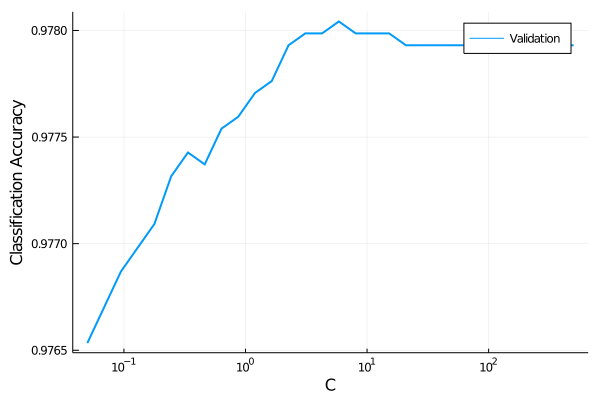

In [23]:
plot(curve.parameter_values,
     curve.measurements,
     xscale=curve.parameter_scale,
     xlab=curve.parameter_name,
     ylab="Classification Accuracy",
     label="Validation", lw=2)

In [24]:
a = round(maximum(curve.measurements), digits=5)

0.97804

In [25]:
best_C = curve.parameter_values[argmax(curve.measurements)]

5.860511487667402

##### Second look at `rbf`

In [75]:
r1 = range(Float64, :C, lower=50, upper=2*10^2, scale=:log10)
r2 = range(Float64, :gamma, lower=10^-4, upper=10^1, scale=:log10)

MLJBase.NumericRange(Float64, :gamma, ... )

In [76]:
svm_rbf_model = SVMClassifier(kernel="rbf", cache_size=1000)
self_tuning_svm_model = TunedModel(model=svm_rbf_model,
                                    tuning=Grid(goal=49),
                                    resampling=CV(), 
                                    measure=accuracy,
                                    acceleration=CPUThreads(),
                                    range=[r1,r2])

DeterministicTunedModel(
    model = SVMClassifier(
            C = 1.0,
            kernel = "rbf",
            degree = 3,
            gamma = "auto",
            coef0 = 0.0,
            shrinking = true,
            tol = 0.001,
            cache_size = 1000,
            max_iter = -1,
            decision_function_shape = "ovr",
            random_state = nothing),
    tuning = Grid(
            goal = 49,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Float64,MLJBase.Bounded,Symbol}[NumericRange{Float64,…} @223, NumericRange{Float64,…} @795],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
  

In [77]:
self_tuning_svm_mach = machine(self_tuning_svm_model, X_stand, y)

Machine{DeterministicTunedModel{Grid,…}} @441 trained 0 times.
  args: 
    1:	Source @546 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @308 ⏎ `AbstractArray{OrderedFactor{2},1}`


In [78]:
z = fit!(self_tuning_svm_mach, rows=train)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @441.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 49 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 49 metamodels: 100%[=========================] Time: 0:02:52


Machine{DeterministicTunedModel{Grid,…}} @441 trained 1 time.
  args: 
    1:	Source @546 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @308 ⏎ `AbstractArray{OrderedFactor{2},1}`


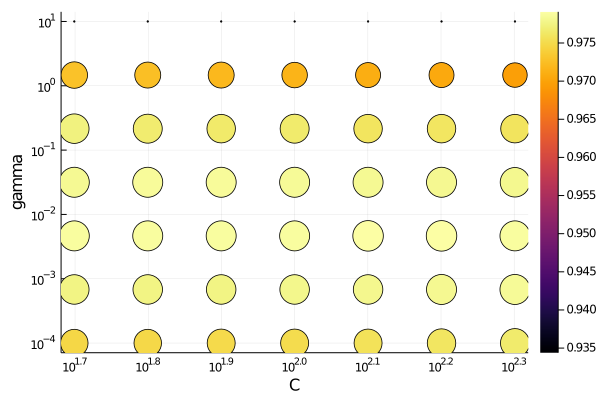

In [79]:
plot(self_tuning_svm_mach)

In [80]:
best_rbf = fitted_params(self_tuning_svm_mach)
best_rbf

(best_model = SVMClassifier @952,
 best_fitted_params = (support = Int32[50, 90, 159, 180, 198, 199, 243, 291, 310, 338  …  12191, 12250, 12272, 12287, 12314, 12372, 12373, 12396, 12410, 12413],
                       support_vectors = [-0.3985913107550849 -0.6689749128132756 … 0.2720794876818213 -0.030910973202165865; -1.0019368160046256 -1.8088140694013153 … -0.717613245749487 -0.7588018088085917; … ; -0.28573092807443273 -1.496253594395517 … 0.2718064697893361 0.19462909310803164; -0.21465938979175175 -0.69341631302427 … 0.40396710336085484 0.020391702831315292],
                       n_support = Int32[335, 330],
                       dual_coef = [-125.99210498948727 -125.99210498948727 … 125.99210498948727 125.99210498948727],
                       coef = nothing,
                       intercept = [-9.297954213582484],
                       fit_status = 0,
                       classes = UInt32[0x00000001, 0x00000002],),)

In [81]:
best_rbf.best_model

SVMClassifier(
    C = 125.99210498948727,
    kernel = "rbf",
    degree = 3,
    gamma = 0.004641588833612777,
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 1000,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @952

In [82]:
best_loss = round(z.report.best_result.measurement[1],digits=5)

0.97909

In [34]:
fn = "Figures/LearningCurve_SVM_RBF_loss:$(best_loss)"
png(replace(fn,'.' => ','))

##### More fitting

In [35]:
best_linear_model = SVMClassifier(kernel="linear", C = best_C)
svm_mach = machine(best_linear_model, X, y)
lf = fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @258.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:07:07


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.979         │ [0.976, 0.976, 0.983, 0.979, 0.979, 0.984] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [36]:
best_rbf_model = SVMClassifier(kernel="rbf", C=best_rbf.best_model.C, gamma=best_rbf.best_model.gamma)
svm_mach = machine(best_rbf_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @787.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:01:56


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.916         │ [0.916, 0.908, 0.912, 0.917, 0.922, 0.922] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


### Learning Curves

In [59]:
data_schedule, training_losses, valid_losses = learn_curve(best_linear_model, X[train,:], y[train], step=200, rng=123)

(d, train_metric, valid_metric) = (10, 1.0, 0.8036711891460495)
(d, train_metric, valid_metric) = (210, 0.9952380952380953, 0.9780526735833999)
(d, train_metric, valid_metric) = (410, 0.9829268292682927, 0.9848363926576217)
(d, train_metric, valid_metric) = (610, 0.9819672131147541, 0.9836392657621708)
(d, train_metric, valid_metric) = (810, 0.9827160493827161, 0.9852354349561053)
(d, train_metric, valid_metric) = (1010, 0.9831683168316832, 0.985634477254589)
(d, train_metric, valid_metric) = (1210, 0.9826446280991735, 0.985634477254589)
(d, train_metric, valid_metric) = (1410, 0.9815602836879432, 0.9848363926576217)
(d, train_metric, valid_metric) = (1610, 0.9826086956521739, 0.9840383080606544)
(d, train_metric, valid_metric) = (1810, 0.9806629834254144, 0.9840383080606544)
(d, train_metric, valid_metric) = (2010, 0.9805970149253731, 0.985634477254589)
(d, train_metric, valid_metric) = (2210, 0.9800904977375565, 0.9852354349561053)
(d, train_metric, valid_metric) = (2410, 0.980497925

(10:200:10010, Any[1.0, 0.9952380952380953, 0.9829268292682927, 0.9819672131147541, 0.9827160493827161, 0.9831683168316832, 0.9826446280991735, 0.9815602836879432, 0.9826086956521739, 0.9806629834254144  …  0.9763702801461632, 0.976218787158145, 0.975725900116144, 0.9758229284903519, 0.9761376248612652, 0.9761129207383279, 0.9766206163655685, 0.9768990634755463, 0.9768603465851172, 0.9769230769230769], Any[0.8036711891460495, 0.9780526735833999, 0.9848363926576217, 0.9836392657621708, 0.9852354349561053, 0.985634477254589, 0.985634477254589, 0.9848363926576217, 0.9840383080606544, 0.9840383080606544  …  0.9852354349561053, 0.984437350359138, 0.9840383080606544, 0.9840383080606544, 0.9840383080606544, 0.9840383080606544, 0.9840383080606544, 0.9840383080606544, 0.984437350359138, 0.9840383080606544])

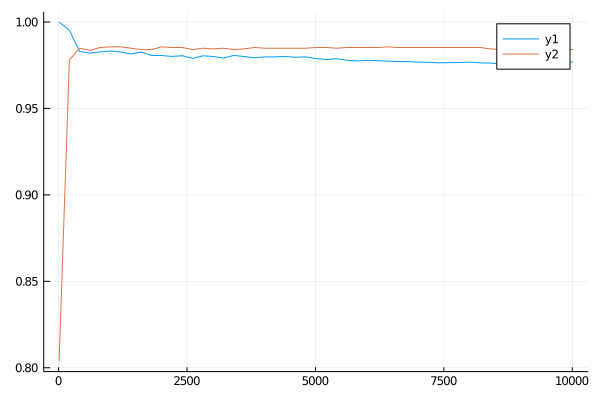

In [60]:
plot(data_schedule, training_losses)
plot!(data_schedule, valid_losses)

In [61]:
data_schedule, training_losses, valid_losses = learn_curve(best_rbf_model, X[train,:], y[train], step=200, rng=123)

(d, train_metric, valid_metric) = (10, 1.0, 0.9158020750199521)
(d, train_metric, valid_metric) = (210, 1.0, 0.9158020750199521)
(d, train_metric, valid_metric) = (410, 1.0, 0.9158020750199521)
(d, train_metric, valid_metric) = (610, 1.0, 0.9162011173184358)
(d, train_metric, valid_metric) = (810, 1.0, 0.9162011173184358)
(d, train_metric, valid_metric) = (1010, 1.0, 0.9162011173184358)
(d, train_metric, valid_metric) = (1210, 1.0, 0.9162011173184358)
(d, train_metric, valid_metric) = (1410, 1.0, 0.9166001596169194)
(d, train_metric, valid_metric) = (1610, 1.0, 0.9166001596169194)
(d, train_metric, valid_metric) = (1810, 1.0, 0.9166001596169194)
(d, train_metric, valid_metric) = (2010, 1.0, 0.9166001596169194)
(d, train_metric, valid_metric) = (2210, 1.0, 0.9166001596169194)
(d, train_metric, valid_metric) = (2410, 1.0, 0.9158020750199521)
(d, train_metric, valid_metric) = (2610, 1.0, 0.9158020750199521)
(d, train_metric, valid_metric) = (2810, 1.0, 0.9162011173184358)
(d, train_metric

(10:200:10010, Any[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Any[0.9158020750199521, 0.9158020750199521, 0.9158020750199521, 0.9162011173184358, 0.9162011173184358, 0.9162011173184358, 0.9162011173184358, 0.9166001596169194, 0.9166001596169194, 0.9166001596169194  …  0.9173982442138867, 0.9177972865123704, 0.9177972865123704, 0.9177972865123704, 0.9169992019154031, 0.9166001596169194, 0.9169992019154031, 0.9177972865123704, 0.9177972865123704, 0.9181963288108539])

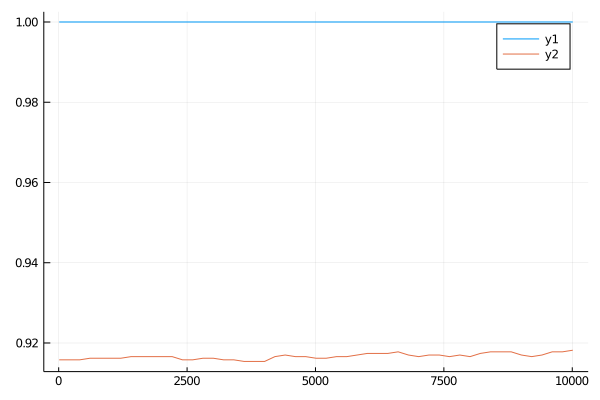

In [62]:
plot(data_schedule, training_losses)
plot!(data_schedule, valid_losses)

# Final Results

Linear SVM

In [63]:
final_svm = SVMClassifier(kernel="linear", C = best_C, cache_size=1000)

SVMClassifier(
    C = 5.860511487667402,
    kernel = "linear",
    degree = 3,
    gamma = "auto",
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 1000,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @594

In [64]:
Final_SVM = machine(final_svm, X, y)

Machine{SVMClassifier} @862 trained 0 times.
  args: 
    1:	Source @298 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @641 ⏎ `AbstractArray{OrderedFactor{2},1}`


In [65]:
fit!(Final_SVM, rows=train, verbosity=2)

┌ Info: Training Machine{SVMClassifier} @862.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{SVMClassifier} @862 trained 1 time.
  args: 
    1:	Source @298 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @641 ⏎ `AbstractArray{OrderedFactor{2},1}`


In [66]:
ŷ2 = MLJ.predict(Final_SVM, X[test,:]);

In [67]:
accuracy(ŷ2, y[test])

0.9811883032222015

In [68]:
confusion_matrix(ŷ2, y[test])

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │    4853     │     85      │
├─────────────┼─────────────┼─────────────┤
│      1      │     16      │     415     │
└─────────────┴─────────────┴─────────────┘


RBF SVM

In [69]:
final_svm_rbf = best_rbf.best_model

SVMClassifier(
    C = 79.37005259840996,
    kernel = "rbf",
    degree = 3,
    gamma = 0.1,
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 1000,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @052

In [70]:
Final_SVM = machine(final_svm, X, y)

Machine{SVMClassifier} @745 trained 0 times.
  args: 
    1:	Source @077 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @754 ⏎ `AbstractArray{OrderedFactor{2},1}`


In [71]:
fit!(Final_SVM, rows=train, verbosity=2)

┌ Info: Training Machine{SVMClassifier} @745.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{SVMClassifier} @745 trained 1 time.
  args: 
    1:	Source @077 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @754 ⏎ `AbstractArray{OrderedFactor{2},1}`


In [72]:
ŷ2 = MLJ.predict(Final_SVM, X[test,:]);

In [73]:
accuracy(ŷ2, y[test])

0.9811883032222015

In [74]:
confusion_matrix(ŷ2, y[test])

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │    4853     │     85      │
├─────────────┼─────────────┼─────────────┤
│      1      │     16      │     415     │
└─────────────┴─────────────┴─────────────┘
